In [231]:
import os 
import numpy as np 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision.datasets import FashionMNIST 
from torchvision import transforms 
from torch.utils.data import DataLoader 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader

In [232]:
torch.manual_seed(123)
np.random.seed(123)

In [233]:
transform = transforms.Compose([ 
transforms.ToTensor(), 
transforms.Normalize((0.5,), (0.5,)) 
])

In [234]:
mnist = FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [235]:
# Split dataset into features and labels

X = [] 
y = [] 
for image, label in mnist: 
    X.append(image.flatten().numpy()) 
    y.append(label) 
X = np.array(X) 
y = np.array(y)


In [236]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [237]:
# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [238]:
# Define architecture of MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # No softmax here!
        return x


In [239]:
# Determine input size

input_size = X.shape[1] 
hidden_size = 64 
output_size = len(np.unique(y))

In [240]:
# Add Loss function and train data

mlp = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mlp.parameters(), lr=0.02) 
epochs = 10 

for epoch in range(epochs): 
    for inputs, labels in train_loader:
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)

        # Zero gradients, backward pass, update weights 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

    # Print loss for last batch in epoch
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.4279
Epoch [2/10], Loss: 0.3560
Epoch [3/10], Loss: 0.4518
Epoch [4/10], Loss: 0.2805
Epoch [5/10], Loss: 0.2726
Epoch [6/10], Loss: 0.4276
Epoch [7/10], Loss: 0.2517
Epoch [8/10], Loss: 0.4657
Epoch [9/10], Loss: 0.1561
Epoch [10/10], Loss: 0.1972


The learning rate (lr) of 0.02 was selected after testing multiple values and observing model performance. This value led to the highest accuracy and macro scores during training and evaluation. A learning rate of 0.02 provided a good balance — it allowed the model to learn quickly without overshooting the optimal weights or causing instability in the training process. Lower values (e.g., 0.001) resulted in slower convergence and underfitting, while higher values caused erratic loss behavior or divergence. Therefore, 0.02 was chosen as the optimal value for this task

In [241]:
# Make predictions without gradient

with torch.no_grad(): 
    predictions = torch.argmax(mlp(X_tensor), dim=1) 
print("Predictions:", predictions.numpy())

Predictions: [9 0 3 ... 3 0 5]


In [242]:
mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [243]:
# Split the test dataset into input features (X_test) and labels (y_test) 

X_test = [] 
y_test = [] 
for image, label in mnist_test: 
   X_test.append(image.flatten().numpy()) 
   y_test.append(label) 
X_test = np.array(X_test) 
y_test = np.array(y_test) 
# Convert test data to PyTorch tensors 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)
# Evaluate the model on the test dataset 
with torch.no_grad(): 
   outputs_test = mlp(X_test_tensor) 
   _, predicted = torch.max(outputs_test, 1) 
   correct = (predicted == y_test_tensor).sum().item() 
   total = y_test_tensor.size(0) 
   accuracy = correct / total 
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.86


In [244]:
def evaluate_model(model, test_loader): 
   model.eval() 
   all_preds = [] 
   all_labels = [] 
   with torch.no_grad(): 
       for inputs, labels in test_loader: 
           outputs = model(inputs) 
           _, preds = torch.max(outputs, 1) 
           all_preds.extend(preds.tolist()) 
           all_labels.extend(labels.tolist()) 
   return all_preds, all_labels 
preds, labels = evaluate_model(mlp, test_loader) 
conf_matrix = confusion_matrix(labels, preds) 
print("Confusion Matrix:") 
print(conf_matrix) 

Confusion Matrix:
[[823   1  16  55   2   3  92   0   8   0]
 [  2 963   2  25   3   0   3   0   2   0]
 [ 14   3 827  14  77   1  62   0   2   0]
 [ 22  15  17 891  25   1  26   0   3   0]
 [  0   2 125  41 745   1  85   0   1   0]
 [  0   0   0   1   0 918   0  53   2  26]
 [132   2 111  41  66   1 632   0  15   0]
 [  0   0   0   0   0  22   0 941   0  37]
 [  3   1   7   8   5   5   8   7 956   0]
 [  0   0   0   0   0   9   0  42   1 948]]


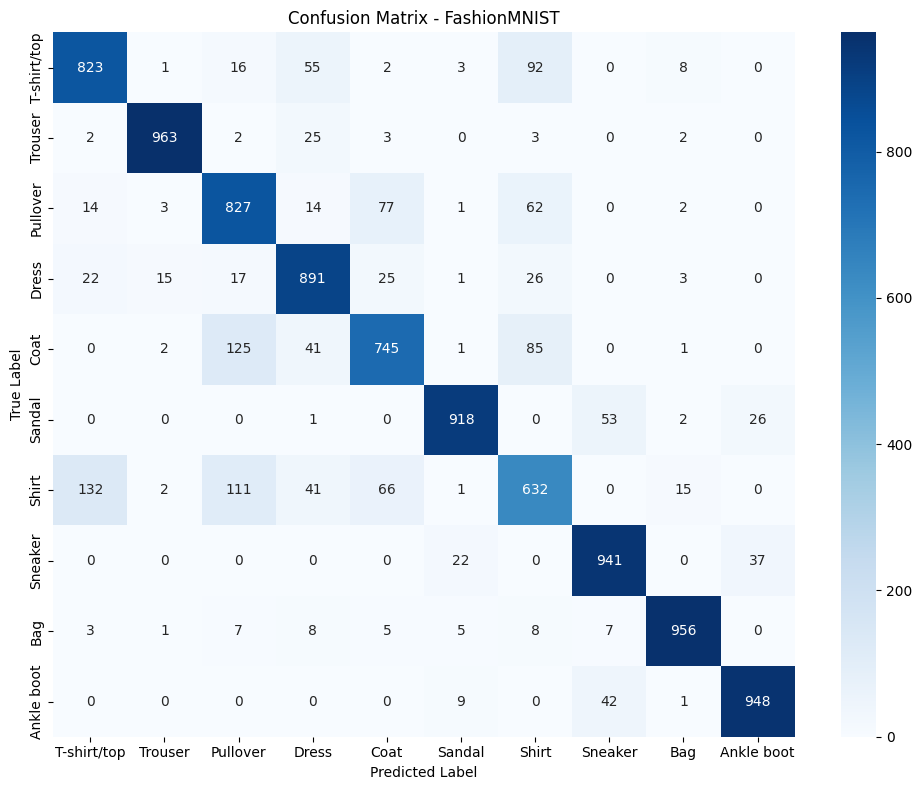

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have `preds` and `labels`
conf_matrix = confusion_matrix(labels, preds)

# Class names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - FashionMNIST')
plt.tight_layout()
plt.show()


From the confusion matrix, we can see that the model performs well overall but struggles particularly with distinguishing between "Shirt" and "T-shirt/top", as well as "Pullover" and "Coat". For example, 132 shirts were misclassified as T-shirts/tops, and 125 coats were misclassified as pullovers. These misclassifications make sense given the visual similarity between these clothing items. Despite these confusions, the model accurately classifies well-defined categories like "Sneaker," "Bag," and "Ankle boot", each with minimal confusion, indicating it has learned to identify more distinct classes effectively.

In [246]:
print(f"Accuracy: {accuracy_score(labels, preds):.2f}")
print(f"Precision (macro): {precision_score(labels, preds, average='macro'):.2f}")
print(f"Recall (macro): {recall_score(labels, preds, average='macro'):.2f}")
print(f"F1 Score (macro): {f1_score(labels, preds, average='macro'):.2f}")

Accuracy: 0.86
Precision (macro): 0.86
Recall (macro): 0.86
F1 Score (macro): 0.86


The Multilayer Perceptron (MLP) model achieved strong overall performance on the FashionMNIST dataset. It reached an accuracy of 86%, with a macro-averaged precision, recall, and F1 score all equal to 0.86. This consistency across metrics indicates that the model performs well across all ten classes, not just the most frequent ones. The macro average treats all classes equally, highlighting that the model generalizes effectively and is not biased toward any particular class.